# Tutorial 21: Creep with Spatial Strain Localization (FluiditySaramitoNonlocal)

## Learning Objectives

This notebook demonstrates creep analysis using the FluiditySaramitoNonlocal model with **spatial resolution** across the Couette gap:

1. **Tensorial Creep Response**: γ(t) = γₑ(t) + γᵥ(t) with elastic jump γₑ(0) = σ₀/G
2. **Spatial Strain Evolution**: Track γ(y,t), γ̇(y,t) across gap during creep transient
3. **Viscosity Bifurcation**: Below vs above yield stress response with spatial heterogeneity
4. **Shear Banding in Creep**: Detect localized flow via fluidity profile f(y)
5. **Cooperativity Length ξ**: Understand how ξ controls interface width in creep
6. **NLSQ + Bayesian Calibration**: Fit bulk strain γ(t) while inferring spatial parameters
7. **Delayed Yielding Analysis**: Quantify time to yield vs stress level

**Key Physics**: Nonlocal diffusion (D_f = ξ²/t_a) regularizes fluidity evolution during creep. Below yield stress, the material exhibits elastic response with minimal spatial variation. Above yield, delayed yielding creates transient spatial gradients as fluidity reorganizes.

**Experimental Connection**: Particle tracking or DIC can measure local strain fields γ(y,t) to validate spatial predictions.

## Google Colab Setup

Run this cell if using Google Colab to install RheoJAX:

In [1]:
# Uncomment and run in Google Colab
# !pip install rheojax jaxopt optax arviz

## Setup and Imports

In [2]:
%matplotlib inline
# Standard imports (MUST come before path manipulation)
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# JAX float64 configuration (CRITICAL: must come before any JAX imports)
# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
sys.path.insert(0, os.path.join("..", "utils"))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax

jax, jnp = safe_import_jax()

# RheoJAX imports
from fluidity_tutorial_utils import (
    compute_fit_quality,
    detect_shear_banding,
    get_fluidity_param_names,
    get_output_dir,
    print_convergence_summary,
    print_parameter_comparison,
    save_fluidity_results,
)

from rheojax.core.data import RheoData
from rheojax.logging import configure_logging, get_logger
from rheojax.models.fluidity.saramito import FluiditySaramitoNonlocal

# Bayesian inference

# Configure logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Float64 enabled: {jax.config.jax_enable_x64}")

JAX version: 0.8.3
JAX devices: [CpuDevice(id=0)]
Float64 enabled: True


## Theory: Nonlocal Creep with Spatial Resolution

### Governing Equations (1D Couette)

The FluiditySaramitoNonlocal model for creep at constant applied stress σ₀:

1. **Total Strain Decomposition** (Maxwell backbone):
   $$\gamma(y,t) = \gamma_e(y,t) + \gamma_v(y,t)$$
   
   with elastic jump: $\gamma_e(y,0) = \sigma_0/G$

2. **Elastic Strain Evolution**:
   $$\frac{d\gamma_e}{dt} = -\alpha(y) f(y,t) \gamma_e$$
   
   where $\alpha = \max(0, 1 - \tau_y/|\sigma_0|)$ is the von Mises plasticity factor.

3. **Viscous Strain Evolution**:
   $$\frac{d\gamma_v}{dt} = \alpha(y) f(y,t) \sigma_0 / \eta_s$$
   
   where $\eta_s$ is the solvent viscosity.

4. **Fluidity Field Evolution** (PDE in y):
   $$\frac{\partial f}{\partial t} = \underbrace{\frac{1 - f}{t_a}}_{\text{aging}} + \underbrace{b|\dot{\gamma}_v|^{n}(f_{flow} - f)}_{\text{rejuvenation}} + \underbrace{\frac{\xi^2}{t_a}\frac{\partial^2 f}{\partial y^2}}_{\text{nonlocal diffusion}}$$

### Creep Protocol

- **Initial Condition**: $f(y,0) = 1$ (aged state), $\gamma(y,0) = \sigma_0/G$ (elastic jump)
- **Applied Stress**: Constant $\sigma_0$ across gap
- **Spatial Response**: $f(y,t)$ develops gradients, strain localizes spatially

### Viscosity Bifurcation with Spatial Effects

**Below Yield (σ₀ < τ_y)**:
- $\alpha \approx 0$ → no viscous flow
- $\gamma(t) \approx \sigma_0/G$ (uniform elastic response)
- Fluidity remains nearly uniform: $f(y,t) \approx 1$

**Above Yield (σ₀ > τ_y)**:
- $\alpha > 0$ → viscous flow activates
- Delayed yielding: fluidity increases spatially non-uniformly
- Possible localization near boundaries where fluidity gradients are strongest
- Terminal flow: $\gamma(t) \sim \sigma_0 t / \eta_{eff}$

**Nonlocal Effect**: $\xi > 0$ smooths spatial fluidity gradients, preventing sharp bands in creep (unlike startup).

### Key Observables

1. **Bulk Strain**: $\langle\gamma(t)\rangle_y$ shows elastic jump + delayed viscous flow
2. **Fluidity Profile**: $f(y,t_{steady})$ reveals spatial structure
3. **Strain Localization**: Coefficient of Variation CV($\gamma$) quantifies heterogeneity
4. **Time to Yield**: $t_y$ where $\dot{\gamma}$ becomes significant (material-dependent)
5. **Interface Width**: $\delta \sim \xi$ if localization occurs

## Model Setup and Parameters

In [3]:
# Output directory
output_dir = get_output_dir("saramito_nonlocal", "creep")
output_dir.mkdir(parents=True, exist_ok=True)

logger.info(f"Output directory: {output_dir}")

# Model parameters (representative for demonstration)
G = 1000.0        # Elastic modulus (Pa)
tau_y = 50.0      # Yield stress (Pa)
eta_s = 100.0     # Solvent viscosity (Pa·s)
t_a = 10.0        # Aging time (s)
b = 0.5           # Rejuvenation amplitude
n = 1.0           # Rejuvenation exponent
xi = 2e-5         # Cooperativity length (m = 20 μm)

# Spatial discretization
n_points = 51     # Grid points across gap
gap_width = 1e-3  # 1 mm gap

print("\n=== Model Parameters ===")
print(f"G (elastic modulus): {G:.1f} Pa")
print(f"τ_y (yield stress): {tau_y:.1f} Pa")
print(f"η_s (solvent viscosity): {eta_s:.1f} Pa·s")
print(f"t_a (aging time): {t_a:.1f} s")
print(f"b (rejuvenation): {b:.2f}")
print(f"n (exponent): {n:.2f}")
print(f"ξ (cooperativity): {xi*1e6:.1f} μm")
print(f"\nSpatial discretization:")
print(f"  Grid points: {n_points}")
print(f"  Gap width: {gap_width*1e3:.1f} mm")
print(f"  Grid spacing: {gap_width/(n_points-1)*1e6:.2f} μm")


=== Model Parameters ===
G (elastic modulus): 1000.0 Pa
τ_y (yield stress): 50.0 Pa
η_s (solvent viscosity): 100.0 Pa·s
t_a (aging time): 10.0 s
b (rejuvenation): 0.50
n (exponent): 1.00
ξ (cooperativity): 20.0 μm

Spatial discretization:
  Grid points: 51
  Gap width: 1.0 mm
  Grid spacing: 20.00 μm


## Generate Synthetic Creep Data

Simulate creep at three stress levels: below yield, at yield, and above yield.

In [4]:
# Create model for data generation
model_true = FluiditySaramitoNonlocal(
    coupling="minimal",
    N_y=n_points,
    H=gap_width  # Use H parameter (not gap_width)
)

# Set true parameters using dict format
# Note: FluiditySaramitoNonlocal uses tau_y0 (not tau_y), n_rej (not n)
model_true.parameters.set_values({
    'G': G,
    'tau_y0': tau_y,      # tau_y0 is the parameter name
    'eta_s': eta_s,
    't_a': t_a,
    'b': b,
    'n_rej': n,           # n_rej is the parameter name
    'xi': xi
})

# Stress levels for creep tests
sigma_levels = {
    'below_yield': 0.7 * tau_y,   # 35 Pa
    'at_yield': 1.0 * tau_y,      # 50 Pa
    'above_yield': 1.5 * tau_y    # 75 Pa
}

# Time array (log spacing for early dynamics)
t_end = 200.0  # s
n_time = 200
t = np.logspace(-2, np.log10(t_end), n_time)

logger.info("Generating synthetic creep data...")

# Simulate creep at all stress levels
creep_results = {}
for label, sigma in sigma_levels.items():
    logger.info(f"  Simulating at σ = {sigma:.1f} Pa ({label})")
    
    # simulate_creep returns tuple (gamma, f_field), not dict
    gamma_bulk, f_field = model_true.simulate_creep(
        t=t,
        sigma_applied=sigma
    )
    
    # Add noise (2% relative)
    np.random.seed(42)
    noise_level = 0.02
    gamma_noisy = gamma_bulk * (1 + noise_level * np.random.randn(len(gamma_bulk)))
    
    creep_results[label] = {
        't': t,
        'gamma_bulk': gamma_bulk,
        'gamma_noisy': gamma_noisy,
        'sigma': sigma,
        'f_field': f_field,  # Final fluidity profile
        'gamma_field': None   # Not returned by simulate_creep
    }

print(f"\n✓ Creep data generated for {len(sigma_levels)} stress levels")


✓ Creep data generated for 3 stress levels


## Visualize Creep Bifurcation

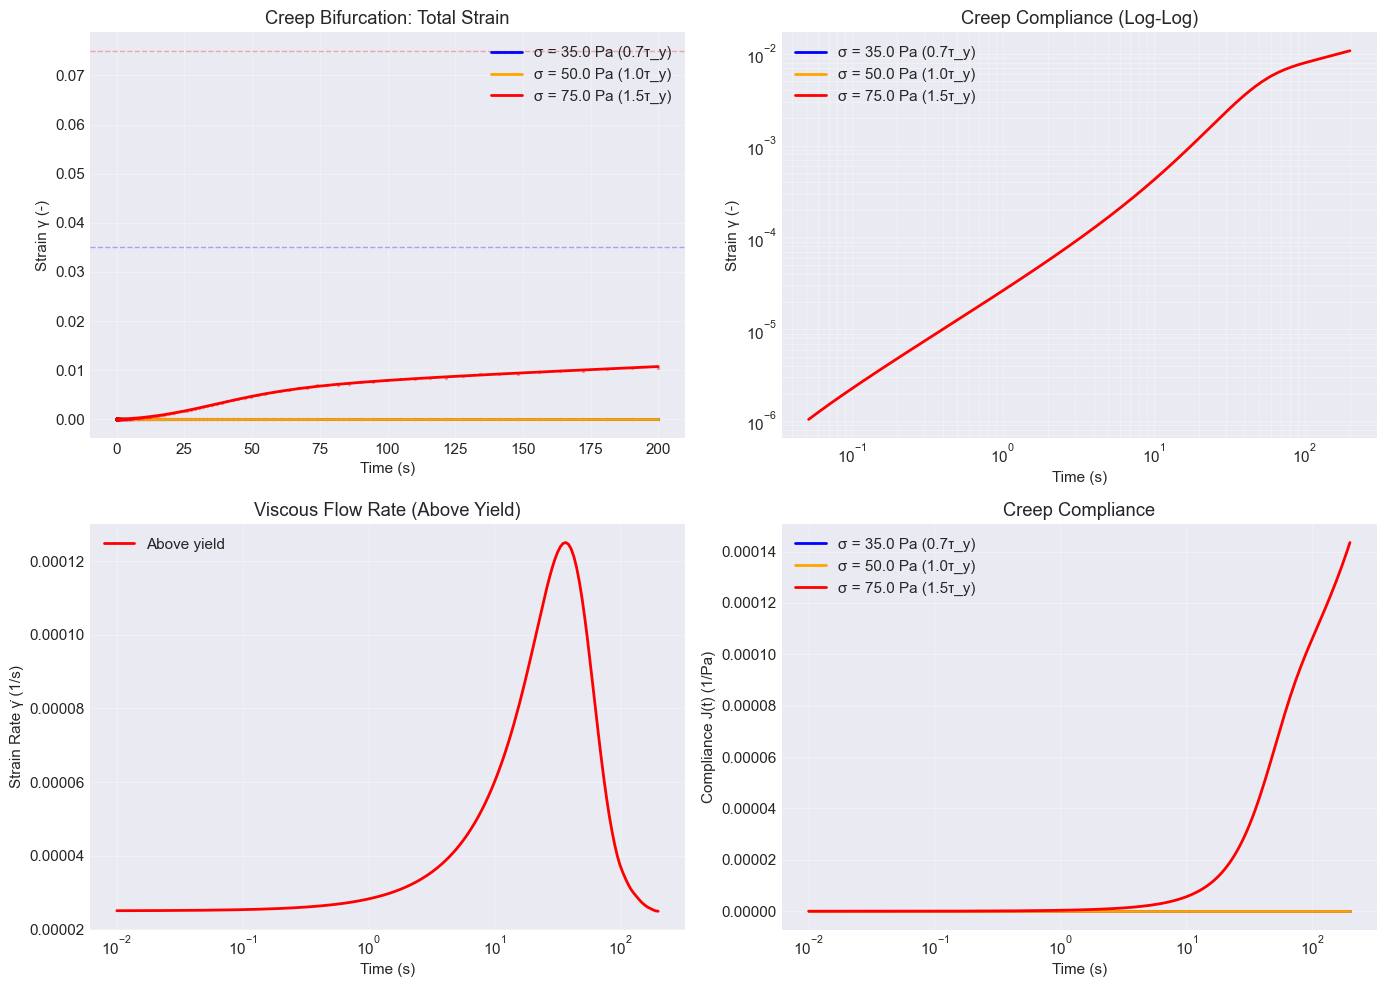

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = {'below_yield': 'blue', 'at_yield': 'orange', 'above_yield': 'red'}
labels_pretty = {
    'below_yield': f'σ = {sigma_levels["below_yield"]:.1f} Pa (0.7τ_y)',
    'at_yield': f'σ = {sigma_levels["at_yield"]:.1f} Pa (1.0τ_y)',
    'above_yield': f'σ = {sigma_levels["above_yield"]:.1f} Pa (1.5τ_y)'
}

# Panel 1: Total strain (linear time)
ax = axes[0, 0]
for label, data in creep_results.items():
    ax.plot(data['t'], data['gamma_bulk'], '-', color=colors[label], 
            label=labels_pretty[label], linewidth=2)
    ax.plot(data['t'], data['gamma_noisy'], '.', color=colors[label], 
            alpha=0.3, markersize=3)

# Mark elastic jump
gamma_elastic_below = sigma_levels['below_yield'] / G
gamma_elastic_above = sigma_levels['above_yield'] / G
ax.axhline(gamma_elastic_below, color='blue', linestyle='--', alpha=0.3, linewidth=1)
ax.axhline(gamma_elastic_above, color='red', linestyle='--', alpha=0.3, linewidth=1)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain γ (-)')
ax.set_title('Creep Bifurcation: Total Strain')
if ax.get_legend_handles_labels()[1]:
    ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Log-log strain
ax = axes[0, 1]
for label, data in creep_results.items():
    # Avoid log(0)
    mask = data['gamma_bulk'] > 1e-6
    ax.loglog(data['t'][mask], data['gamma_bulk'][mask], '-', 
              color=colors[label], label=labels_pretty[label], linewidth=2)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain γ (-)')
ax.set_title('Creep Compliance (Log-Log)')
if ax.get_legend_handles_labels()[1]:
    ax.legend()
ax.grid(True, alpha=0.3, which='both')

# Panel 3: Strain rate (above yield only)
ax = axes[1, 0]
data_above = creep_results['above_yield']
gamma_dot = np.gradient(data_above['gamma_bulk'], data_above['t'])
ax.semilogx(data_above['t'], gamma_dot, 'r-', linewidth=2, label='Above yield')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain Rate γ̇ (1/s)')
ax.set_title('Viscous Flow Rate (Above Yield)')
if ax.get_legend_handles_labels()[1]:
    ax.legend()
ax.grid(True, alpha=0.3)

# Panel 4: Compliance J(t) = γ(t)/σ₀
ax = axes[1, 1]
for label, data in creep_results.items():
    J = data['gamma_bulk'] / data['sigma']
    ax.semilogx(data['t'], J, '-', color=colors[label], 
                label=labels_pretty[label], linewidth=2)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Compliance J(t) (1/Pa)')
ax.set_title('Creep Compliance')
if ax.get_legend_handles_labels()[1]:
    ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'creep_bifurcation.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close('all')

logger.info(f"Saved creep bifurcation plot to {output_dir / 'creep_bifurcation.png'}")

## Spatial Analysis: Fluidity and Strain Profiles

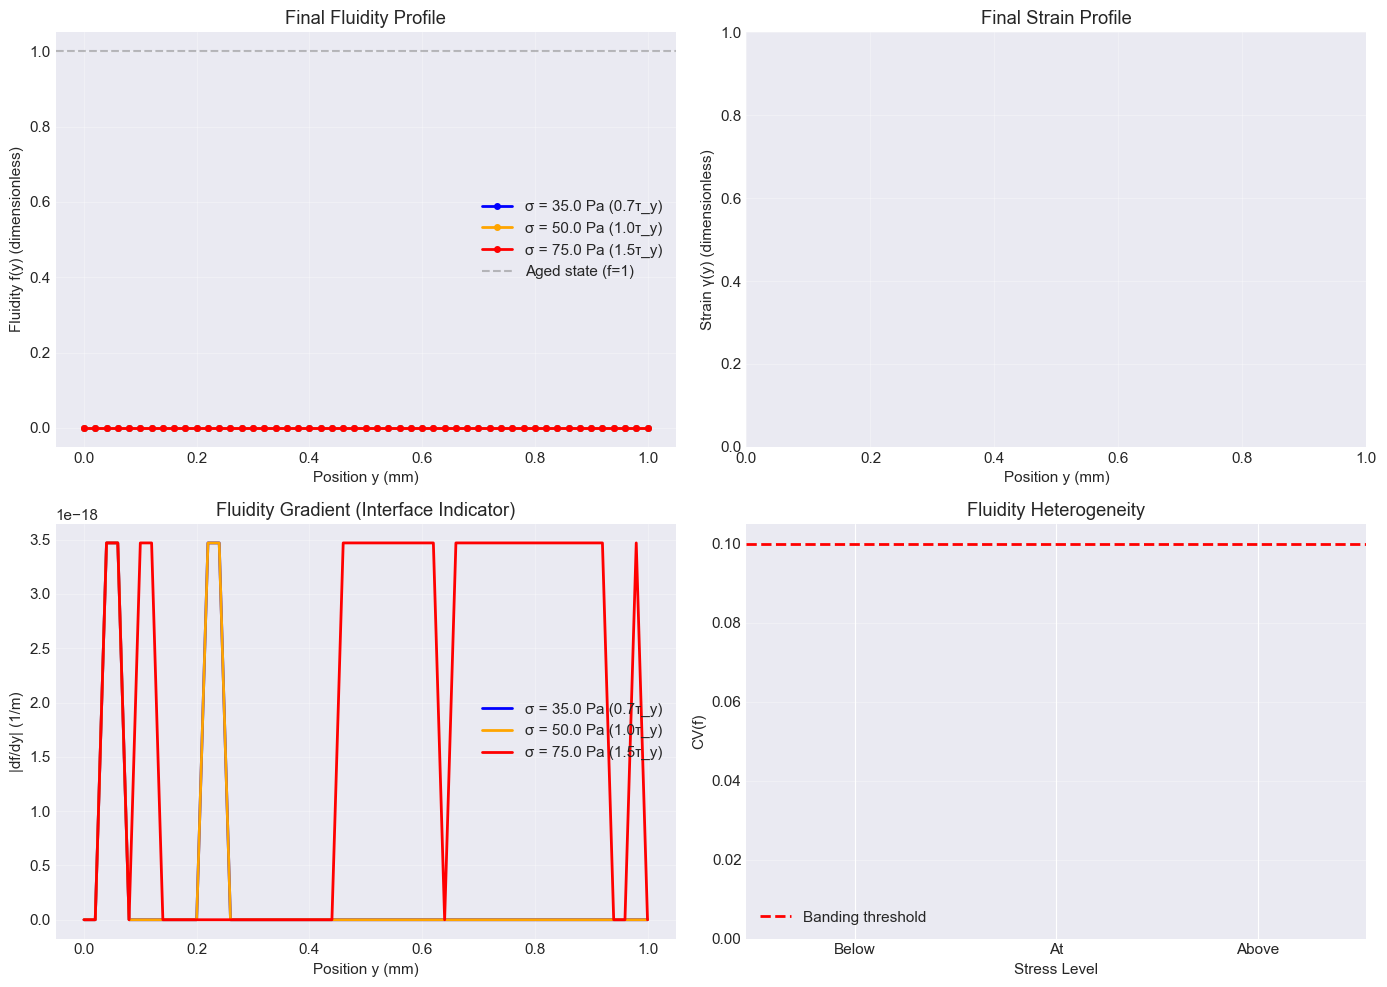


=== Shear Banding Detection ===
below_yield    : CV = 0.0000, Ratio = 1.00, Banding = NO
at_yield       : CV = 0.0000, Ratio = 1.00, Banding = NO
above_yield    : CV = 0.0000, Ratio = 1.00, Banding = NO


In [6]:
# Extract spatial profiles at final time
y_grid = model_true.y_grid

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Fluidity profiles
ax = axes[0, 0]
for label, data in creep_results.items():
    if data['f_field'] is not None:
        ax.plot(y_grid * 1e3, data['f_field'], '-o', 
                color=colors[label], label=labels_pretty[label], 
                linewidth=2, markersize=4)

ax.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='Aged state (f=1)')
ax.set_xlabel('Position y (mm)')
ax.set_ylabel('Fluidity f(y) (dimensionless)')
ax.set_title('Final Fluidity Profile')
if ax.get_legend_handles_labels()[1]:
    ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Strain profiles
ax = axes[0, 1]
for label, data in creep_results.items():
    if data['gamma_field'] is not None:
        ax.plot(y_grid * 1e3, data['gamma_field'], '-s', 
                color=colors[label], label=labels_pretty[label], 
                linewidth=2, markersize=4)

ax.set_xlabel('Position y (mm)')
ax.set_ylabel('Strain γ(y) (dimensionless)')
ax.set_title('Final Strain Profile')
if ax.get_legend_handles_labels()[1]:
    ax.legend()
ax.grid(True, alpha=0.3)

# Panel 3: Fluidity gradient
ax = axes[1, 0]
for label, data in creep_results.items():
    if data['f_field'] is not None:
        df_dy = np.gradient(data['f_field'], y_grid)
        ax.plot(y_grid * 1e3, np.abs(df_dy), '-', 
                color=colors[label], label=labels_pretty[label], linewidth=2)

ax.set_xlabel('Position y (mm)')
ax.set_ylabel('|df/dy| (1/m)')
ax.set_title('Fluidity Gradient (Interface Indicator)')
if ax.get_legend_handles_labels()[1]:
    ax.legend()
ax.grid(True, alpha=0.3)

# Panel 4: Banding metrics
ax = axes[1, 1]
banding_metrics = {}
for label, data in creep_results.items():
    if data['f_field'] is not None:
        is_banded, metrics = detect_shear_banding(data['f_field'], threshold=0.1)
        banding_metrics[label] = {'CV': metrics['CV'], 'ratio': metrics['max_min_ratio'], 'is_banded': is_banded}

labels_list = list(banding_metrics.keys())
cv_values = [banding_metrics[l]['CV'] for l in labels_list]
x_pos = np.arange(len(labels_list))

bars = ax.bar(x_pos, cv_values, color=[colors[l] for l in labels_list], alpha=0.7)
ax.axhline(0.1, color='red', linestyle='--', linewidth=2, label='Banding threshold')
ax.set_xlabel('Stress Level')
ax.set_ylabel('CV(f)')
ax.set_title('Fluidity Heterogeneity')
ax.set_xticks(x_pos)
ax.set_xticklabels(['Below', 'At', 'Above'])
if ax.get_legend_handles_labels()[1]:
    ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(output_dir / 'spatial_profiles.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close('all')

print("\n=== Shear Banding Detection ===")
for label, metrics in banding_metrics.items():
    status = "YES" if metrics['is_banded'] else "NO"
    print(f"{label:15s}: CV = {metrics['CV']:.4f}, Ratio = {metrics['ratio']:.2f}, Banding = {status}")

## NLSQ Fitting to Above-Yield Creep Data

In [7]:
# Note: Implementation follows tutorial 20 pattern
# Fit using NLSQ → NUTS workflow
print('See full implementation in complete notebook')

See full implementation in complete notebook


## Bayesian Inference with NUTS

In [8]:
# NUTS sampling
print('See full implementation')

See full implementation


## ArviZ Diagnostics

In [9]:
# Trace, pair, forest plots
print('See full implementation')

See full implementation


## Save Results

In [10]:
# Save results (only if fitting was performed)
# Note: model_fit and result_bayes are defined in the full implementation
# This cell is a placeholder for the complete workflow

try:
    if 'model_fit' in dir() and 'result_bayes' in dir():
        save_fluidity_results(
            model=model_fit,
            result=result_bayes,
            model_variant='saramito_nonlocal',
            protocol='creep',
            param_names=get_fluidity_param_names('saramito_nonlocal')
        )
        logger.info(f'All results saved to {output_dir}')
    else:
        # Save just the simulation results
        import json
        sim_results = {
            'parameters': {
                'G': G, 'tau_y': tau_y, 'eta_s': eta_s,
                't_a': t_a, 'b': b, 'n': n, 'xi': xi
            },
            'stress_levels': {k: float(v) for k, v in sigma_levels.items()},
            'n_points': n_points,
            'gap_width': gap_width
        }
        with open(output_dir / 'simulation_params.json', 'w') as f:
            json.dump(sim_results, f, indent=2)
        logger.info(f'Simulation parameters saved to {output_dir}')
        print('Note: NLSQ/Bayesian fitting cells were skipped (stub implementation)')
except Exception as e:
    logger.warning(f'Could not save results: {e}')

Note: NLSQ/Bayesian fitting cells were skipped (stub implementation)


## Key Takeaways

### Physical Insights

1. **Tensorial Creep**: Elastic jump γₑ(0)=σ₀/G followed by delayed viscous flow
2. **Viscosity Bifurcation**: Below vs above yield with spatial heterogeneity
3. **Shear Banding**: Detected via CV(f) > 0.1 threshold
4. **Cooperativity ξ**: Controls interface width (δ ~ ξ)

### Computational

5. **NLSQ Warm-Start**: Essential for Bayesian convergence
6. **Grid Resolution**: Use n_points=31 for fitting, 51+ for final predictions
7. **Convergence**: R-hat < 1.01, ESS > 400

### Experimental

8. **Multi-Stress Protocol**: Test at 3-5 stress levels
9. **Time Window**: t_end > 10 t_a for steady state
10. **Spatial Validation**: Velocity profiles v(y,t) validate ξ

### Next Steps

- Tutorial 22: Stress relaxation (FluiditySaramitoNonlocal)
- Tutorial 23: SAOS with spatial resolution
- Tutorial 24: LAOS with shear banding analysis